# Can Google Trends detect deviations from market forecasts in the U.S. labor market?

## Required packages

In [1]:
import sys
import pickle
from pathlib import Path
from typing import List
import datetime
from dateutil.relativedelta import relativedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.seasonal import STL
from statsmodels.discrete.discrete_model import Logit
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


sys.path.append("../../src")
from ftrends.construction import RBC
from stattools.test import RandomWalkTest
from visualization.series import series_plot

## Employment statistics

### Unemployment Rate

- Both the employment statistics and the average of economists' forecasts are extracted from Bloomberg.
- Schedule of releases for the employment situation is [here](https://www.bls.gov/schedule/news_release/empsit.htm).

In [2]:
# Create data
file = Path("../../data/raw/macro/bloomberg.xlsx")
sheet_name = "UnemploymentRateForecast" # or "NonfarmPayroll"
df_uempr = pd.read_excel(file, sheet_name=sheet_name, skiprows=[0, 2, 3, 4], index_col=0)
df_uempr.index = pd.to_datetime(df_uempr.index)
df_uempr.index.name = "Date"
df_uempr = df_uempr[df_uempr.index.is_month_end] # because of monthly data 
df_uempr.iloc[:, 1:] = df_uempr.iloc[:, 1:].shift(1) # shift 1-lag for forecast
df_uempr["UNRATE_FORECAST_DATE"] = pd.to_datetime(df_uempr["UNRATE_FORECAST_DATE"], format="%Y%m%d")
df_uempr.dropna(inplace=True)

Depict the series 

In [3]:
_df = df_uempr.iloc[:, :2]
_df["DIFF"] = _df["UNRATE"] - _df["UNRATE_FORECAST"]

layout_kwargs = dict(
    width=800,
    height=400,
    font_size=15,
    legend={"x":0.99, "y":1.1, "xanchor":"right", "yanchor":"bottom","orientation":"h"},
    xaxis={"title":"Date"},
    yaxis={"title":"Unemployment Rate [%]", "side":"left", },
    yaxis2={"title":"Difference [%]", "side":"right", "overlaying":'y'},
    hovermode="x",
    template="plotly_dark"
)
fig = series_plot(_df, **layout_kwargs)
fig.show()

## Google Trends

In [4]:
# create data
# kw = "unemployment"
kw = "jobs"
# kw = "unemployment office"
# kw = "unemployment benefits"
file = Path("../../data/raw/google/daily/{}/svi_cat0.pkl".format(kw.replace(" ", "-")))
with file.open("rb") as f:
    _dfs = pickle.load(f)
rbc = RBC(_dfs)
df_svi = rbc.knit(direction="forward", max_num_zeros=100)

# display
display(df_svi.tail())

# plot
layout_kwargs = dict(
    width=800,
    height=400,
    font_size=15,
    legend={"x":0.99, "y":1.1, "xanchor":"right", "yanchor":"bottom","orientation":"h"},
    xaxis={"title":"Date"},
    yaxis={"title":"Unemployment Rate [%]", "side":"left", },
    yaxis2={"title":"Difference [%]", "side":"right", "overlaying":'y'},
    hovermode="x",
    template="plotly_dark"
)
# fig = series_plot(df_svi.iloc[6000:, :], **layout_kwargs))
fig = series_plot(df_svi, **layout_kwargs)
fig.show()

,jobs
date,
2022-10-17,10.616976
2022-10-18,10.741881
2022-10-19,11.116598
2022-10-20,9.867542
2022-10-21,8.243769


周期性がパッと見ある

## Tentative Analysis

目的としては

- 市場予測から上／下振れるか当てたい

予測方法
1. Google Trendsだけを用いてあてられる？
   - 日次データを月次ごとに分けて，それぞれの期間でSTL分解して，トレンド項を取り出す．
     $$
     D_{yyyymm} = \{ SVI_{start}, \ldots, SVI_{end} \} \to \{ Trend_{start}, \ldots, Trend_{end} \} \to Slope_{yyyymm} = Trend_{end} - Trend_{start}
     $$
   - トレンド項によって抽出されたグラフから，月次のスロープ（月次変化）を新たなファクターに加える．
   - "上ぶれ", "ドンピシャ"，"下ぶれ"を推定
     - ロジットモデルが一つ
     - 例えば，9月の市場予想は8月のトレンドから見通されたと仮定．その仮定のもとで，Slopの変化がpositiveであれば，上方修正．negativeであれば逆に下方修正．
       - このとき”ドンピシャ”をどう設定するか？
         - $Slope$がボラよりも大きければ，$Slope=0$
         - RW性があれば，トレンドとはいえないとして，$Slope=0$ 

In [5]:
# "上ぶれ", "ドンピシャ"，"下ぶれ"の分布
df_uempr.assign(sign=np.sign(df_uempr["UNRATE"] - df_uempr["UNRATE_FORECAST"])).groupby("sign").agg(["count"])

,UNRATE,UNRATE_FORECAST,UNRATE_FORECAST_DATE
,count,count,count
sign,,,
-1.0,145,145,145
0.0,51,51,51
1.0,73,73,73


In [6]:
# サンプル期間は2005/1/1 - 2019/12/31
sample_date_range = (datetime.datetime(2005, 1, 1), datetime.datetime(2019, 12, 31))

# サンプル期間内で処理を月次で回す
def loop_monthly(data_range):
    def _loop_monthly(func):
        def process(*args, **kwargs):
            start = sample_date_range[0]
            outputs = {}
            while (start < sample_date_range[1]):
                end  = start + relativedelta(months=1, days=-1)
                output = func(*args, start, end, **kwargs)
                start = end + relativedelta(days=1)
                outputs[end] = output
            return outputs
        return  process
    return _loop_monthly
    
# 月次スロープ算出
@loop_monthly(data_range=sample_date_range)
def slope(df, start, end):
    mask = (df.index >= start) & (df.index <= end)
    _df = df[mask]
    stl = STL(_df).fit()
    slope = stl.trend[-1] - stl.trend[0]
    vol = np.std(stl.resid)
    res = {
        "slope":slope,
        "vol":vol
    }
    return res

# 月次でRW性テスト
@loop_monthly(data_range=sample_date_range)
def rw(df, start, end, method="normal"):
    mask = (df.index >= start) & (df.index <= end)
    _df = df[mask]
    rw = RandomWalkTest(method=method).test(_df.to_numpy().flatten(), q=3)
    res = {
        "rw_pvalue":rw["p-value"]
    }
    return res

# 一括処理
@loop_monthly(data_range=sample_date_range)
def make_factors(df, start, end, rw_method="normal"):
    mask = (df.index >= start) & (df.index <= end)
    # RW
    _df = df[mask]
    rw = RandomWalkTest(method=rw_method).test(_df.to_numpy().flatten(), q=3)
    # Slope and vol
    stl = STL(_df).fit()
    slope = stl.trend[-1] - stl.trend[0]
    vol = np.std(stl.resid)
    res = {
        "rw_pvalue":rw["p-value"],
        "slope":slope,
        "vol":vol
    }
    return res

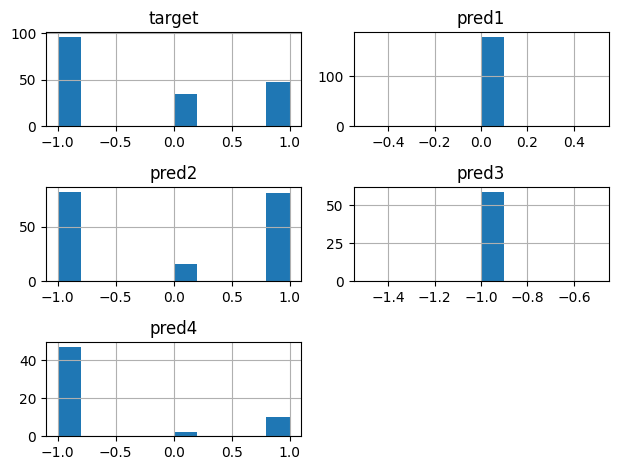

pred2


,-1,0,1
accuracy,0.463687,0.737430,0.513966
recall,0.427083,0.057143,0.437500
precision,0.500000,0.125000,0.259259
f1,0.460674,0.078431,0.325581
count,179.000000,179.000000,179.000000


pred4


,-1,0,1
accuracy,0.457627,0.677966,0.644068
recall,0.758621,0.000000,0.076923
precision,0.468085,0.000000,0.100000
f1,0.578947,0.000000,0.086957
count,59.000000,59.000000,59.000000


In [7]:
# 修正の予想
# make factor
_res = make_factors(df_svi, rw_method="Lo-MacKinlay")
_df = pd.DataFrame.from_dict(_res).T
# concatenate
_df = pd.concat([df_uempr, _df], axis=1).dropna()
_df["target"] = np.sign(_df["UNRATE"] - _df["UNRATE_FORECAST"])
_df["diff_slope"] = _df["slope"].diff(1)

# prediction 1 (Slope-RW)
_df["diff_slope1"] = ((_df["rw_pvalue"] < 0.05) * _df["slope"]).diff(1)
_df["pred1"] = np.sign(_df["diff_slope1"])

# prediction 2 (Slope-VOL)
_df["diff_slope2"] = ((np.abs(_df["slope"]) > 1*_df["vol"]) * _df["slope"]).diff(1)
_df["pred2"] = np.sign(_df["diff_slope2"])

_df.dropna(inplace=True)

# prediction 3, 4 (Logit, KNN)
# 10年間分学習，一ヶ月先予測
res_pred = {}

i = 0
training_interval = 10*12
while i + training_interval < len(_df):
    exog =  ["slope", "diff_slope", "vol"]
    X_train = _df.iloc[i:i+training_interval, :].loc[:, exog]
    Y_train = _df.iloc[i:i+training_interval, :].loc[:, "target"]
    X_test = _df.iloc[[i+training_interval], :][exog]

    lr = LogisticRegression()
    lr.fit(X_train, Y_train)
    lr_pred = lr.predict(X_test)
    
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train, Y_train)
    knn_pred = knn.predict(X_test)
    
    res_pred[_df.index[i+training_interval]] = {
        "pred3":lr_pred[0],
        "pred4":knn_pred[0],
        "pos_count":Y_train[Y_train > 0].count(),
        "zero_count":Y_train[Y_train == 0].count(),
        "neg_count":Y_train[Y_train < 0].count(),
    }
    
    i += 1
    
df_pred = pd.DataFrame.from_dict(res_pred).T

_df = pd.concat([_df, df_pred], axis=1)

# plot
use_cols = ["target"] + [f"pred{i}" for i in range(1, 5)]
_df[use_cols].hist()
plt.tight_layout()
plt.show()

# metrics
def _metrics(df, target_col, pred_col, categories):
    metrics = {}
    for c in categories:
        _df = df.loc[:, [target_col, pred_col]]
        _df.dropna(inplace=True)
        _df[target_col] = _df[target_col].apply(lambda x: 1 if x == c else 0)
        _df[pred_col] = _df[pred_col].apply(lambda x: 1 if x == c else 0)
        
        metrics[c] = {
            "accuracy":accuracy_score(_df[target_col], _df[pred_col]),
            "recall":recall_score(_df[target_col], _df[pred_col]),
            "precision":precision_score(_df[target_col], _df[pred_col]),
            "f1":f1_score(_df[target_col], _df[pred_col]),
            "count": len(_df)
        }
    res = pd.DataFrame.from_dict(metrics)
    return res
for pred in ["pred2", "pred4"]:
    print(pred)
    res = _metrics(_df, "target", pred, [-1, 0, 1])
    display(res)

(pred1, pred2作成段階)
上方修正を当てる確率は，ランダムよりも大きいが微妙すぎてつらい
→ もう少し複雑にする必要がある．

cf. About metrics

Let $C = \{0, \ldots, n\}$ be a set of classes, the define positive subclass and negative subclass for $c \in C$ as follows:
$$
P_c = \{ c \},\quad N_c = C \setminus \{ c \}.
$$
With the positive and negative label, metrics can be defined as conventional forms:
$$
{accuracy}_c = \frac{{TP}_c + {TN}_c}{{TP}_c + {TN}_c + {FP}_c + {FN}_c}
$$
$$
{recall}_c = \frac{{TP}_c}{{TP}_c + {FN}_c}
$$
$$
{precision}_c = \frac{{TP}_c}{{TP}_c + {TN}_c}
$$
$$
{F1}_{c} = 2 \left( \frac{1}{{recall}_c} + \frac{1}{{precision}_c} \right)^{-1}
$$